## Setup

As before, We begin by loading the necessary packages and setting a
temporary output directory.

In [1]:
setwd('C:/Users/tm/Downloads/utas/thesis/chapter1/channel/poems')
library(poems)
OUTPUT_DIR='C:/Users/tm/Downloads/utas/thesis/chapter1/channel/poems'

# function to round to any arbitrary value
round_any <- function(x, accuracy, f = round) {
  f(x/ accuracy) * accuracy
}

### read data

In [2]:
#this is the land area of channel
baselayer=read.csv('baselayer.csv')
baselayer=subset(baselayer, grid == 0)
landarea=c(as.numeric(row.names(baselayer)))

In [3]:
#this is the reindexed validation area of channel against land area
identity=read.csv('identity.csv')

In [4]:
#population size
#estimated via cormack jolly seber
# https://github.com/je-suis-tm/Devil-Project/blob/main/Chapter1/Channel/jolly%20seber%20channel.ipynb
population_est=read.csv('population.csv')
population_size=as.array(population_est$population)

In [5]:
#this is the validation area of channel
valid=read.csv('validation.csv')
valid=subset(valid, target == 1)
validation_target=c(as.numeric(row.names(valid)))

In [6]:
#habitat suitability map
#estimated via vegetation,altitude
# https://github.com/je-suis-tm/Devil-Project/blob/main/Chapter1/Channel/habitat%20suitability%20channel.ipynb
suitability=read.csv('suitability.csv')

In [7]:
#set the floor of habitat suitability to 0.7
suitability$pred=(suitability$pred-min(suitability$pred))/(max(suitability$pred)-min(suitability$pred))*(1-0.7)+0.7

### Step 1: Build the population model for the study region

##### Study region

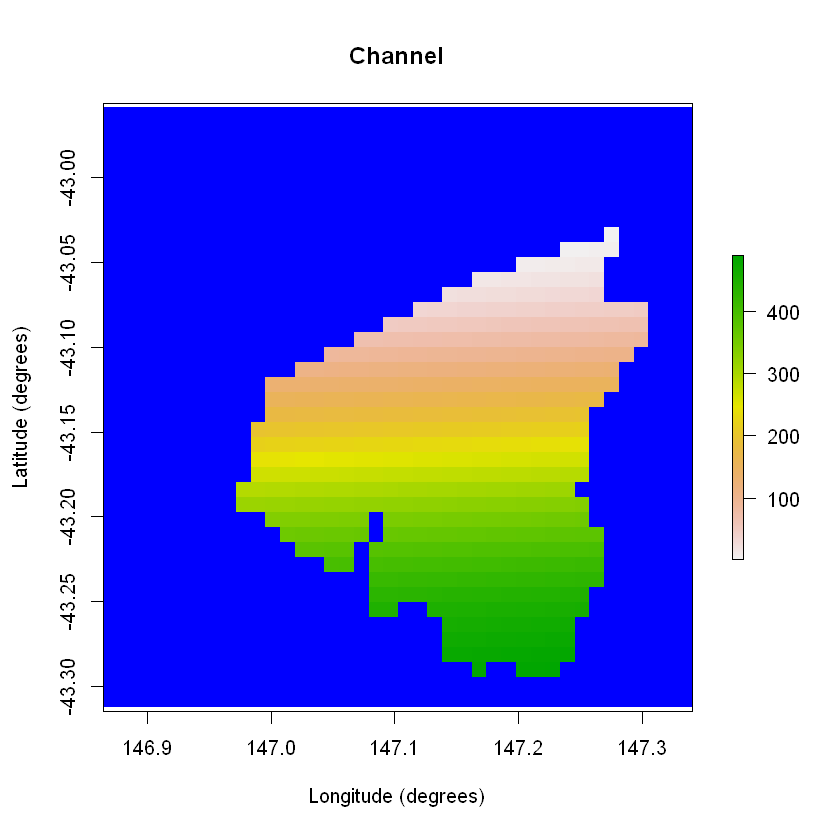

In [8]:
#build the raster of channel
coordinates <- data.frame(x = rep(seq(146.87034933151315, 147.3427777451974, 0.011910710342106035), 40),
                          y = rep(seq(-43.307913, -42.95820098835541, 0.008842800291114784),each= 40))
template_raster <- Region$new(coordinates = coordinates)$region_raster # full extent
template_raster[][-landarea] <- NA 

region <- Region$new(template_raster = template_raster)

raster::plot(region$region_raster, main = "Channel",
             xlab = "Longitude (degrees)", ylab = "Latitude (degrees)",
             colNA = "blue",)

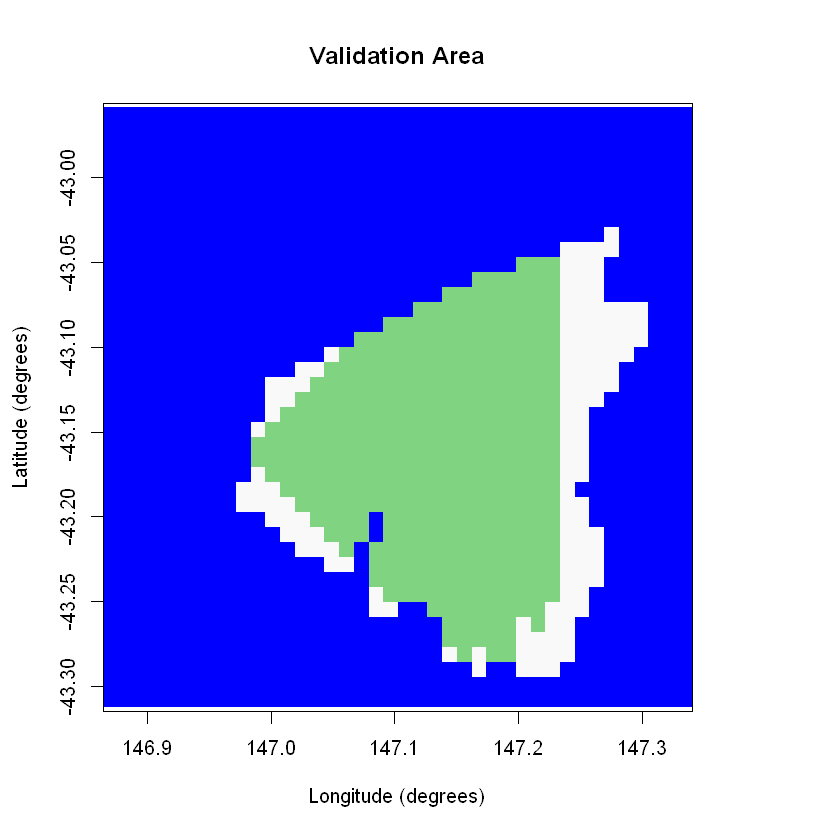

In [9]:
# Example validation area
example_vt_raster <- region$region_raster
example_vt_raster[landarea] <- 50
example_vt_raster[validation_target] <- 1000
example_vt_raster[-landarea]<- NA
raster::plot(example_vt_raster, main = "Validation Area",alpha=0.5,legend = FALSE,
             xlab = "Longitude (degrees)", ylab = "Latitude (degrees)",
             colNA = "blue")

### Habitat suitability

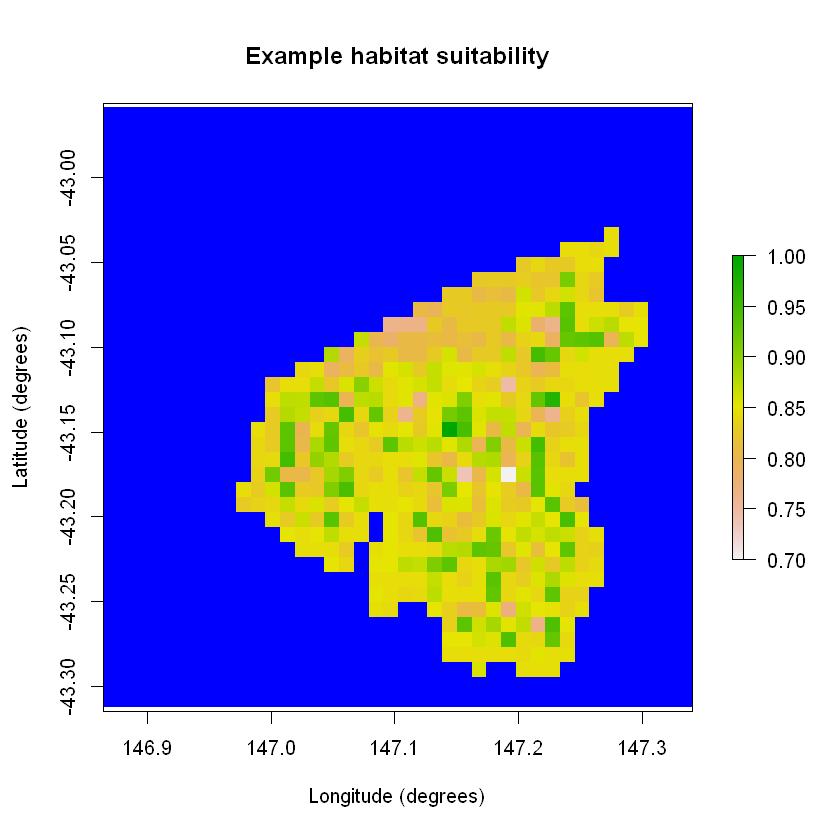

In [10]:
# Example habitat suitability
example_hs=suitability$pred
example_hs_raster <- region$region_raster
example_hs_raster[region$region_indices] <- example_hs
raster::plot(example_hs_raster, main = "Example habitat suitability",
             xlab = "Longitude (degrees)", ylab = "Latitude (degrees)",
             colNA = "blue")

### Environmental correlation

Next, we'll define a distance-based spatial correlation for applying
environmental stochasticity within our model. The generated correlation
data is compacted for computational efficiency (with large-scale
models).

In [11]:
# Distance-based environmental correlation (via a compacted Cholesky decomposition)
env_corr <- SpatialCorrelation$new(region = region, 
                                   amplitude = 0.496, 
                                   breadth = 80, 
                                   distance_scale = 1000)
correlation <- env_corr$get_compact_decomposition(decimals = 2)

## Step 2: Setup the translocation function

Here we generate a custom *Translocation* class object. This object can
be used to translocate populations from one location to another, or as
shown here, to introduce populations at defined locations and timesteps.
The function could also be expanded to introduce varying number of
animals at each site. For simplicity sake, this example releases the
same number of animals at all locations.

### Introduction sites and times

Here we define the introduction sites by matching
`region$region_indices` to our introduction locations.

We also define the timesteps that the introductions should occur. These
timesteps are sequential from 1, and are not defined by, for example,
calendar years.

In [12]:

intro_cells <- c(466,467,468)

intro_times <- c(2, 3, 4)


### Translocation function

Here we define the custom `translocation` function. It's simply a `list`
object, with a nested function that uses parameters from the model to
make changes to the simulated populations.


In [13]:
# User-defined translocation function (list-nested) and alias ####

translocation <- list(
  
  # Function parameters (passed to function in params list)
  intro_cells = intro_cells, # cells where pops are introduced
  intro_timesteps = intro_times, # timesteps when introduced
  trans_n = 1, # translocated abundances. If not provided by LHS == 50
  region_indices = region$region_indices,
  
  # Function definition
  translocation_function = function(params) {
    # Unpack parameters (used at every time step)
    intro_cells <- params$intro_cells
    intro_timesteps <- params$intro_timesteps
    simulator <- params$simulator
    stages <- params$stages
    populations <- params$populations
    abundances <- params$abundance
    region_indices <- params$region_indices
    tm <- params$tm # timestep
    sa <- params$stage_abundance
    trans_n <- params$trans_n
    # if introduction at timestep, introduce pops
    if (tm %in% intro_timesteps) {
      # take stage abundance at timestep
      new_sa <- array(sa, c(stages, populations))
      # identifies location of introduction
      trans_loc <- which(region_indices == intro_cells[which(intro_timesteps == tm)])
      # add n individuals regardless of K
      new_sa[trans_loc] <-  new_sa[trans_loc] + trans_n
      return(new_sa)
    } else {
      # else return pops as they are
      new_sa <- array(sa, c(stages, populations))
      return(new_sa)
    }
  }
)
translocation_aliases <- list(intro_cells = "translocation$intro_cells",
                              intro_times = "translocation$intro_timesteps",
                              trans_n = "translocation$trans_n",
                              region_indices = "translocation$region_indices")

## Step 3: Build generators for dynamically generating model parameters



### Dispersal generator

This generator controls dispersal across our region based on mean
dispersal distance and proportion of dispersers.


In [14]:
# Distance-based dispersal generator
dispersal_gen <- DispersalGenerator$new(region = region,
                                        dispersal_max_distance = 25, # in km 
                                        distance_scale = 1000,
                                        dispersal_friction = DispersalFriction$new(),
                                        inputs = c("dispersal_p", "dispersal_b"),
                                        decimals = 5)
dispersal_gen$calculate_distance_data() # pre-calculate
test_dispersal <- dispersal_gen$generate(input_values = list(dispersal_p = 0.33074, 
                                                             dispersal_b = 9.81105))
#head(test_dispersal$dispersal_data[[1]])

as(<dsCMatrix>, "dgTMatrix") is deprecated since Matrix 1.5-0; do as(as(., "generalMatrix"), "TsparseMatrix") instead



### Capacity generator

In [15]:
# Initial abundance and carrying capacity generated via example habitat suitability
capacity_gen <- Generator$new(description = "Capacity generator",
                              example_hs = example_hs, # template attached
                              inputs = c("initial_n", "density_max"),
                              outputs = c("initial_abundance", "carrying_capacity"))
capacity_gen$add_generative_requirements(list(initial_abundance = "function",
                                              carrying_capacity = "function"))
capacity_gen$add_function_template("initial_abundance",
                                   function_def = function(params) {
                                       stats::rmultinom(1, size = params$initial_n,
                                                      prob = params$example_hs)[,1]
                                   },
                                   call_params = c("initial_n", "example_hs"))
capacity_gen$add_function_template("carrying_capacity",
                                   function_def = function(params) {
                                     round(params$density_max*params$example_hs)
                                   },
                                   call_params = c("density_max", "example_hs"))
# capacity_gen$generate(input_values = list(initial_n = 15, density_max = 15)) # test

### density dependent

In [16]:
# Define neighborhoods (of up to 9 adjacent cells) based on a 1.414 km range from each 
# grid cell for density dependence calculations (using a dispersal generator)
distance_data <- dispersal_gen$distance_data[[1]]
nh_data <- distance_data[which(distance_data$distance_class <= 1.414), 2:1]

neighborhoods <- as.list(1:length(landarea))
for (i in 1:nrow(nh_data)) {
  neighborhoods[[nh_data$source_pop[i]]] <- c(neighborhoods[[nh_data$source_pop[i]]],
                                               nh_data$target_pop[i])
}
#neighborhoods[1:3] # examine

In [17]:
# User-defined function for Ricker logistic density dependence via neighborhoods
density_dependence <- list(
  neighborhoods = neighborhoods,
  function (params) {
    
    # Apply logistic density dependence using neighborhoods
    growth_rate_max <- params$growth_rate_max
    nh_density_abundance <- unlist(lapply(params$neighborhoods,
                                          function (nh_indices) {
                                            sum(params$density_abundance[nh_indices])
                                          }))
    nh_carrying_capacity <- unlist(lapply(params$neighborhoods,
                                          function (nh_indices) {
                                            sum(params$carrying_capacity[nh_indices])
                                          }))
    occupied_indices <- params$occupied_indices
    growth_rate <- growth_rate_max*(1 - (nh_density_abundance[occupied_indices]/
                                           nh_carrying_capacity[occupied_indices]))
    params$transition_array[, , occupied_indices] <-
      params$apply_multipliers(params$transition_array[, , occupied_indices],
                               params$calculate_multipliers(growth_rate))
    
    
    # Remove fecundities for single thylacines
    single_indices <- which(nh_density_abundance == 1)
    params$transition_array[, , single_indices] <-
      (params$transition_array[, , single_indices]*as.vector(+(!params$fecundity_mask)))
    
    return(params$transition_array)
  }
)

## Step 4: Build a template model

Using the generators we've built we can now test if our simple
population model works as expected.

In [18]:
leslie_matrix=c(0.0,
 0.7009803921568627,
 1.4863013698630136,
 1.7678571428571428,
 1.5714285714285714,
 0.25,
 0.7094330411487038,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.539462266272108,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.4188660822974074,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.32532441479719504,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.24889530742081187,
 0.0)
agegroup=c("y0","y1","y2","y3","y4","y5")

In [19]:
# Population (simulation) model template for fixed parameters
stage_matrix <- matrix(leslie_matrix, nrow = 6, ncol = 6, byrow = TRUE,
                       dimnames = list(agegroup,agegroup ))

In [20]:
#stage_matrix # examine
model_template <- PopulationModel$new(region = region,
                                      time_steps = 7, # years
                                      years_per_step = 1,
                                      populations = region$region_cells, 
                                      stages = 6,
                                      stage_matrix = stage_matrix,
                                      demographic_stochasticity = TRUE,
                                      standard_deviation = 0.05,
                                      
                                      density_dependence = density_dependence,
                                      harvest = FALSE, # No harvest
                                      dispersal = dispersal_gen,
                                      translocation = translocation,
                                      dispersal_source_n_k = list(threshold = 0.92, cutoff = 0),
                                      simulation_order = c("translocation", "results", "transition", "dispersal"),
                                      random_seed = 20230210,
                                      attribute_aliases = translocation_aliases,
                                      results_selection = c("abundance"))

## Step 5: Run multiple simulations

In order to explore the model parameter space to find the best models,
we generate Latin hypercube samples of model and generator parameters to
be simulated, using the *LatinHypercubeSampler* class. This class has
functionality for generating sample parameters via Uniform, Normal,
Lognormal, Beta, and Triangular distributions. For our example we only
generate 10 samples. Typically however, a user would need to generate
thousands to tens of thousands, of samples.

### Define the latin-hypercube for sampling

In [21]:
# Generate sampled values for variable model parameters via LHS
lhs_gen <- LatinHypercubeSampler$new()

#logistic growth model 0.74
# https://github.com/je-suis-tm/Devil-Project/blob/main/Chapter1/Channel/logistic%20population%20growth%20channel.ipynb
lhs_gen$set_uniform_parameter("growth_rate_max", lower = 0.2, upper = 0.9, decimals = 2)
lhs_gen$set_uniform_parameter("initial_n", lower = as.integer(population_size[7])-50,
                              upper = as.integer(population_size[7])+50, decimals = 0)

lhs_gen$set_uniform_parameter("density_max", lower = 0.1, upper = 3, decimals = 2)
lhs_gen$set_uniform_parameter("dispersal_p", lower = 0.1, upper = 0.5, decimals = 4)
lhs_gen$set_uniform_parameter("dispersal_b", lower = 6, upper = 12, decimals = 2)
sample_data <- lhs_gen$generate_samples(number = 100)

#save as pickle
save(sample_data, file="sample data.Rda")

## Step 6: Extract results from simulations

Now that the simulations have run, we can extract the modelled
abundances. We now wish to collate summary results for each of our
simulations via the *ResultsManager* class. This manager loads the
results from each sample simulation into an intermediate
*PopulationResults* class object, which dynamically generates further
results. We need to define functions for calculating summary metrics, as
well as any matrices (one row of values per simulation) that we may be
interested in examining.

We can see from above that the `run_output$summary` shows that there
were a number of simulations that didn't complete successfully:

In [22]:
# Create a simulation manager and run the sampled model simulations
sim_manager <- SimulationManager$new(sample_data = sample_data,
                                     model_template = model_template,
                                     generators = list(capacity_gen, dispersal_gen),
                                     parallel_cores = 2,
                                     results_dir = OUTPUT_DIR)
run_output <- sim_manager$run(results_dir = tempdir())
run_output$summary
#dir(OUTPUT_DIR, "*.RData") # includes result files 
#dir(OUTPUT_DIR, "*.txt") # plus simulation log

[1] "100 of 100 sample models ran and saved results successfully with warnings"



### Extract results


In [23]:
#validation area id
iden=identity$ID

In [24]:
results_manager <- ResultsManager$new(simulation_manager = sim_manager,
                                      simulation_results = PopulationResults$new(),
                                      summary_metrics = c("p2","p3","p4"),
                                      summary_matrices = c("n"),
                                      iden=identity$ID,
                                      summary_functions = list(
                                          
                                          #results refer to actual output rdata file
                                        p2 = function(results,iden) {
                                          sum(results$abundance[iden,2])                                            
                                        },                                          
                                        p3 = function(results,iden) {
                                          sum(results$abundance[iden,3])
                                        },
                                        p4 = function(results,iden) {
                                          sum(results$abundance[iden,4])
                                        },
                                        n = "abundance"),
                                      parallel_cores = 2)
gen_output <- results_manager$generate()
gen_output$summary
#dir(OUTPUT_DIR, "*.txt") # plus generation log
# results_manager$summary_metric_data
# results_manager$summary_matrix_list

[1] "100 of 100 summary metrics/matrices generated from sample results successfully"

In [25]:
#save as pickle
save(results_manager, file="models.Rda")

### validate

In [26]:
#load pickle files so no need to retrain
load("models.Rda")
load("sample data.Rda")

In [27]:
#showna
validation_var=results_manager$summary_metric_data
validation_var[!complete.cases(validation_var),]

,index,p2,p3,p4
,<int>,<dbl>,<dbl>,<dbl>
1,1,NA,NA,NA
2,2,NA,NA,NA
3,3,NA,NA,NA
8,8,111,NA,NA
11,11,NA,NA,NA
12,12,186,NA,NA
18,18,122,NA,NA
20,20,NA,NA,NA
21,21,174,NA,NA


In [28]:
#list of na
remove_index=which(!complete.cases(validation_var))

In [29]:
# Create a validator for selecting the 'best' example models
if (length(remove_index)==0)    {
    validator <- Validator$new(simulation_parameters = sample_data,
                           simulation_summary_metrics =
                             validation_var[-1],
                           observed_metric_targets = c(p2=as.integer(population_size[8]/2),
                                                       p3=as.integer(population_size[9]/2),
                                                       p4=as.integer(population_size[10]/2)),
                           output_dir = OUTPUT_DIR)

} else    {
    validator <- Validator$new(simulation_parameters = sample_data[-remove_index,],
                           simulation_summary_metrics =
                             validation_var[-remove_index,][-1],
                           observed_metric_targets = c(p2=as.integer(population_size[8]/2),
                                                       p3=as.integer(population_size[9]/2),
                                                       p4=as.integer(population_size[10]/2)),
                           output_dir = OUTPUT_DIR)
}

In [30]:
validator$run(tolerance = 0.25, output_diagnostics = TRUE)

12345678910
12345678910


Warning message:
"Validation function generated warning: All parameters are "none" transformed."


In [31]:
#rescale weights as they dont sum up to one
weights=validator$selected_simulations 
weights$weight=weights$weight/sum(weights$weight)

In [32]:
#get result
colSums(sample_data[weights$index,]*replicate(length(sample_data), weights$weight))

growth_rate_max       initial_n     density_max     dispersal_p     dispersal_b 
      0.5394484     112.5451331       1.5035686       0.2827581       8.9092184

In [33]:
dir(OUTPUT_DIR, "*.pdf") # plus validation diagnostics (see abc library documentation)

[1] "validation_diagnostics.pdf"